In [ ]:
# Simple GA for TSP
import numpy as np
import re
import random
import matplotlib.pyplot as plt

# get coordinates of the cities
cities = np.empty((50,2))
with open("file-tsp.txt", mode='r') as f:
  lines = f.readlines()
for l in range(len(lines)):
  coords = lines[l].split()
  cities[l] = [float(i) for i in coords]

# function for dist between twodimensional arrays:
def distance(c1, c2):
  x1 = cities[c1]
  x2 = cities[c2]
  d = np.sqrt(
        np.square(abs(x1[0] - x2[0]))
          + np.square(abs(x1[1] - x2[1]))
        )
  return d

# evaluation function
def calc_fitnesses(population):
  fitnesses = []
  for candidate in population:
    fitness = 0
    position = candidate[0]
    for city in candidate:
      fitness += distance(position, city)
      position = city 
    # fitness += distance(position, candidate[0]) # to force the cycle connect last position to first city
    fitnesses.append(fitness)
  fitnesses = np.array(fitnesses)
  return fitnesses

def select_candidates(population, fitnesses, M, selection='tournament', t=2):
  if selection=='tournament':
    new_population = []
    for i in range(M):
      participants = random.choices(population, k=t)
      outcome = calc_fitnesses(participants)
      new_population.append(participants[np.argmin(outcome)])
  else:
    fitness2 = [abs(f - max(fitnesses)) for f in fitnesses]
    new_population = random.choices(population, weights=fitness2, k=M)
  return new_population 

def recombine(pool, N):
  new_population = []
  while len(pool) > 1:
    p1 = pool.pop()
    p2 = pool.pop()
    cut_point1 = np.random.randint(0, len(p1))
    cut_point2 = np.random.randint(0, len(p1))
    if cut_point2 < cut_point1:
      interm = cut_point2
      cut_point2 = cut_point1
      cut_point1 = interm
    cut_len = cut_point2 - cut_point1
    c1 = np.empty(50, dtype=int)
    c1.fill(-1)
    c2 = np.empty(50, dtype=int)
    c2.fill(-1)
    for i in range(cut_point1, cut_point2):
      c1[i] = p1[i]
      c2[i] = p2[i]

    # fill children with parents
    for c, p in [(c1, p2), (c2, p1)]:
      index_c = cut_point2
      index_p = cut_point2
      if index_c > 49:
        index_c = 0
      if index_p > 49:
        index_p = 0
      for i in range(50-cut_len):
        while p[index_p] in c:
          index_p +=1
          if index_p > 49:
            index_p = 0
        c[index_c] = p[index_p]
        index_p +=1
        index_c +=1
        if index_c > 49:
          index_c = 0
        if index_p > 49:
          index_p = 0
    new_population.append(c1)
    new_population.append(c2)
  new_population = np.array(new_population)
  return new_population

def mutate(population, p_m):
  for i in range(len(population)):
    if np.random.random() <= p_m:
      p = population[i]
      swap_i = np.random.randint(0, 50)
      swap_j = np.random.randint(0, 50)
      while swap_j == swap_i:
        swap_j = np.random.randint(0, 50)
      interm = p[swap_i]
      p[swap_i] = p[swap_j]
      p[swap_j] = interm
      population[i] = p
  return population

def local_search(population):
  for i in range(len(population)):
    p = population[i]
    cut_point1=1
    cut_point2=1
    distance_1 = 0
    distance_2 = 0
    for index in range(len(p)-1):
      new_distance = distance(p[index], p[index+1])
      if new_distance > min(distance_1, distance_2):
        if distance_1 < distance_2:
          distance_1 = new_distance
          cut_point1 = index
        else:
          distance2 = new_distance
          cut_point2 = index
    if cut_point2 < cut_point1:
      inter = cut_point1
      cut_point1 = cut_point2 
      cut_point2 = inter

    dist_og = distance_1 + distance_2
    dist_new = distance(p[cut_point2], p[cut_point1+1])
    dist_new += distance(p[cut_point1], p[cut_point2+1])

    if dist_new < dist_og:
      p[cut_point1:(cut_point2)] = list(reversed(p[cut_point1:(cut_point2)]))
      population[i] = p
  return population

def doGenetics(N, max_k, p_m, local=False, selection='tournament', t=2):
  # N: size of population
  # max_k: max iter
  # p_m: mutation rate
  # local: use memetic approach using swap
  # selection: what selection approach to use
  #     roulette = our special variant of roulette wheel selection
  #     tournament = binary tournament selection
  #       if tournament, t represents the tournament size

  # iteration counter
  k = 0

  # initialize the population  
  population = np.empty((N, 50), dtype=int)
  for i in range(N):
    population[i] = np.random.permutation(50)


  # apply local search
  if local:
    population = local_search(population)

  # train initial fitness
  fitnesses = calc_fitnesses(population)

  while k < max_k:
    # training loop
    mating_pool = select_candidates(population, fitnesses, N, selection, t=t)

    # create new population through selection, recombination and mutation
    new_population = recombine(mating_pool, N)
    N = len(new_population) # if first population was odd this is the new even number

    # mutation
    population = mutate(new_population, p_m)

    if local:
      population = local_search(population)
    # train initial fitness
    fitnesses = calc_fitnesses(population)
    min_f = min(fitnesses)
    print(f"ended iteration {k+1}, it has best fitness of {min_f}")
    k+=1

  best_fitness = min(fitnesses)
  best_solution_i = np.argmin(fitnesses)
  best_solution = population[best_solution_i]
  return best_fitness, best_solution

In [ ]:
max_k = 50
best_fitness, best_solution = doGenetics(1000, max_k, 0.01, local=True, selection="tournament", t=5)

ended iteration 1, it has best fitness of 405.1056890645998
ended iteration 2, it has best fitness of 380.86518179373894
ended iteration 3, it has best fitness of 363.1425485458776
ended iteration 4, it has best fitness of 367.5421278452995
ended iteration 5, it has best fitness of 350.21464494532734
ended iteration 6, it has best fitness of 319.9495109730765
ended iteration 7, it has best fitness of 308.3032728358402
ended iteration 8, it has best fitness of 326.4479085912476
ended iteration 9, it has best fitness of 311.18723035489774
ended iteration 10, it has best fitness of 290.8375785886679
ended iteration 11, it has best fitness of 293.62271528291177
ended iteration 12, it has best fitness of 293.3336162693252
ended iteration 13, it has best fitness of 272.68897849467675
ended iteration 14, it has best fitness of 273.3410386868142
ended iteration 15, it has best fitness of 251.68703082518218
ended iteration 16, it has best fitness of 256.4765019084391
ended iteration 17, it has 

Text(0.5, 1.0, 'Best solution after 150 iterations with fitness 129.59640318163957')

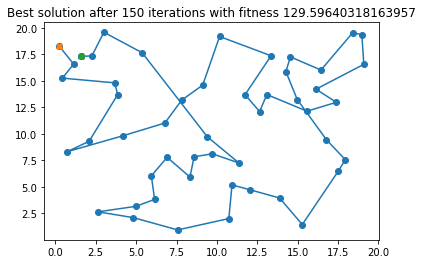

In [ ]:
xs = []
ys = []
for ci in best_solution:
  coords = cities[ci]
  xs.append(coords[0])
  ys.append(coords[1])
plt.plot(xs, ys, '-o')
plt.plot(xs[0], ys[0], 'X')
plt.plot(xs[49], ys[49], 'X')
plt.title(f"Best solution after {max_k} iterations with fitness {best_fitness}".format(max_k, best_fitness))
# ended iteration 30, it has best fitness of 332.3029756792001 N=2000, local = False